## Makas Yusuf
## Hervoit Alexandre

# TP 3: Zoom d'images par minimisation de la variation totale



Dans ce TP, nous allons considérer une méthode d'optimisation pour zoomer des
images. Nous considèrerons un modèle d'échantillonnage simple. \'Etant donnée une
image de départ $u$, de taille $KN\times KN$, l'image sous-échantillonnée,
dans un rapport $K$,  $v$ est définie par
$$v_{i,j}=\frac{1}{K^2} \sum_{k,l=0}^{K-1} u_{Ki+k,Kj+l},
$$
pour $(i,j)\in \{0,\ldots,N-1\}^2$. On note l'opérateur d'échantillonnage ainsi
défini $Q$. On a donc $v=Q(u)$.

On notera 
$${\mathcal C}=\{w\in{\mathbb R}^{(KN)^2}, Q(w)=v\}.
$$

On sait donc que $u\in {\mathcal C}$, c'est la seule information dont nous sommes sûr
concernant $u$.

Pour définir une méthode d'optimisation permettant de zoomer une image $u$,
il est donc naturel de considérer le problème:
$$(P):\left\{\begin{array}{l}
\mbox{minimiser } E(w) \\ 
\mbox{sous la contrainte } w\in{\mathcal C},
\end{array}\right.
$$
pour une énergie $E$ bien choisie.

Nous considèrerons dans cet exercice la minimisation d'une approximation différentiable de la variation
totale. Pour cela, nous définissons 
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots, KN-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).

Par ailleurs, nous approximerons le module du gradient, dans la variation totale, par
$$\varphi_\beta (|\nabla w_{i,j}|^2),
$$
avec
$$\varphi_\beta (t)=\sqrt{t+\beta},
$$
pour $\beta>0$. En pratique, on prendra $\beta=0.01$. L'approximation de la variation totale est alors définie par
$$E_\beta(w)=\sum_{i,j=0}^{KN-1} \varphi_\beta \left( |\nabla w_{i,j}|^2 \right).
$$


## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




In [2]:
# u = 255 * mpimg.imread("barbara.png")
# N,K = 100,3
# u = u[0:N*K,200:200+N*K]

# v = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         total = 0
#         for k in range(K):
#             for l in range(K):
#                 total += u[K*i+k,K*j+l]
#         v[i,j] = 1/K**2 * total

        


# plt.figure(figsize = (15,30))
# plt.subplot(1,3,1)
# plt.imshow(u,cmap='gray')
# plt.subplot(1,3,2)
# plt.imshow(v,cmap='gray')


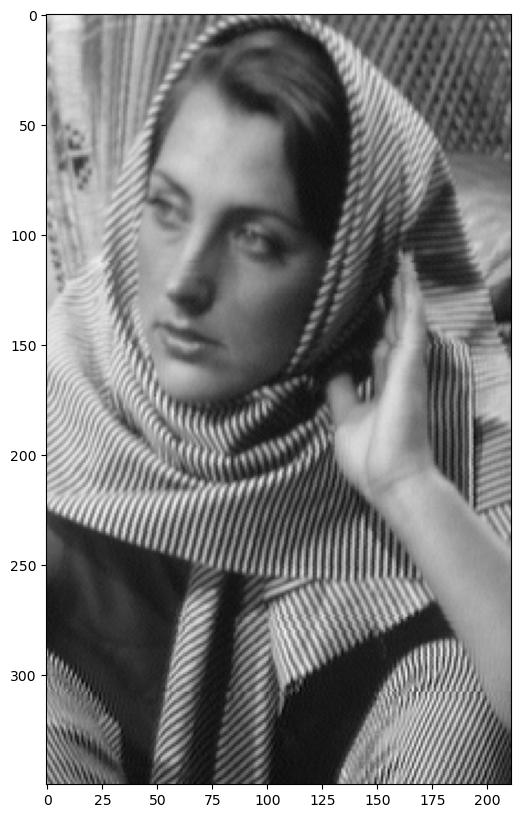

In [3]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction calculant l'échantillonnage

In [4]:
def echantillonne_image(inp,K,adjoint):
    sx , sy = np.shape(inp)  
    
    if adjoint==0:
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += inp[K*x+k,K*y+l]
                out[x,y]=tmp
                
    else:
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= inp[x,y]
           
    
    return out/(K*K)

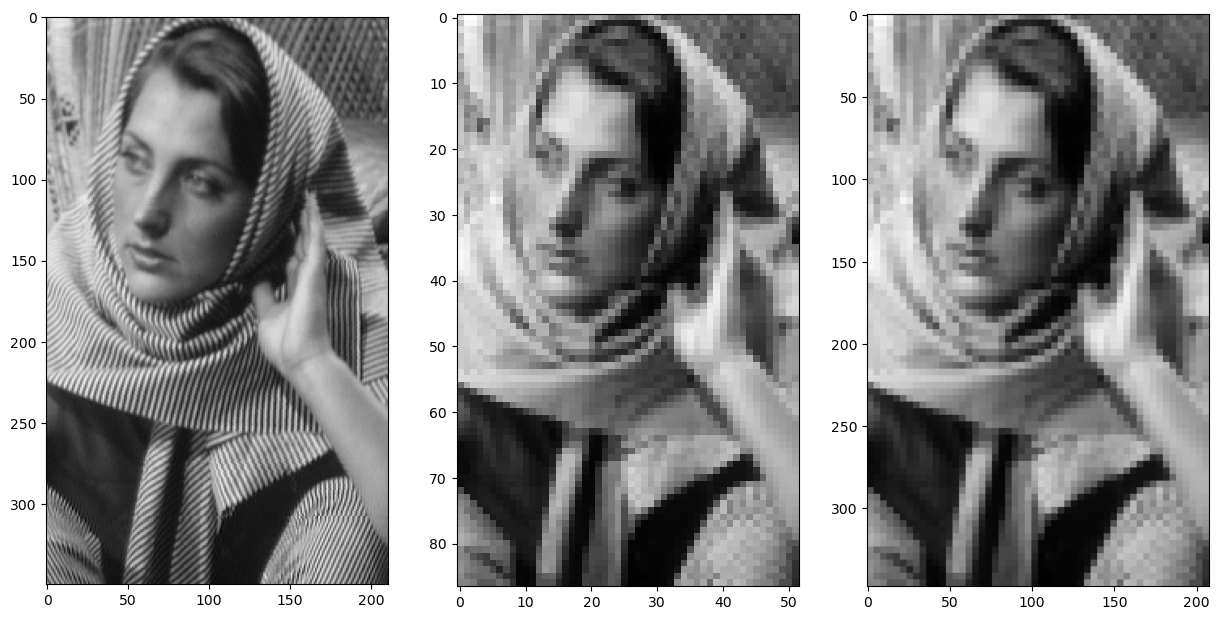

In [5]:
K=4

# Sous-echantillonnage
v = echantillonne_image(u,K,0)

# Sur-echantillonnage
w = K**2*echantillonne_image(v,K,1)

plt.figure(figsize = (15,30))
plt.subplot(1,3,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(v,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(w,cmap='gray')



Nous réduisons d'abord la résolution de l'image initiale pour créer une version sur laquelle travailler. Ensuite, nous appliquons un zoom pour obtenir une image de la taille d'origine. Nous constatons alors que cette image est pixelisée. Nous entreprenons alors des méthodes itératives pour tenter de retrouver l'image initiale.

## Fonction calculant itérativement le minimiseur

In [6]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
################################
def phi(img,beta):
    
    return np.sqrt(img+beta)

def phi_p(img,beta):

    return np.sqrt(1/(4*(img+beta)))
################################
def grad_TV(out,beta):
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi_p(tmpx*tmpx+tmpy*tmpy,beta)
    
    tmpx1 = grad_x(tmp*tmpx,1)
    tmpy1 = grad_y(tmp*tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1) 
    
    return grad
 
def TV(out,beta):
    sx , sy = np.shape(out)
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi(tmpx*tmpx+tmpy*tmpy,beta)
 
    return np.sum(np.abs(tmp))
################################


def projection(img,v,K):
    tmp = echantillonne_image(img,K,0)
    tmp1 = (K*K)*echantillonne_image(tmp-v,K,1)

    return img - tmp1

################################
  
def zoom_TV(v,K,nbIter):
    beta = 1
    pas = beta/4

    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_TV(out,beta)
        out = out - pas * d
        out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', TV(out,beta) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        
    return out

In [7]:
K=4
v = u[0:100,0:100] 
#v=np.copy(u)
#v = echantillonne_image(u,K,0)
w = zoom_TV(v,K,100)

iter =  0 fonction =  703601.9001332215 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  690662.3582636963 max contrainte =  1.1368683772161603e-13
iter =  2 fonction =  681277.2202739937 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  674048.6018858129 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  668261.8182184392 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  663494.8242948544 max contrainte =  1.4210854715202004e-13
iter =  6 fonction =  659479.386331876 max contrainte =  1.1368683772161603e-13
iter =  7 fonction =  656036.1930028152 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  653040.458985677 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  650402.4143944388 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  648055.6661297295 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  645949.9462075388 max contrainte =  1.4210854715202004e-13
iter =  12 fonction =  64404

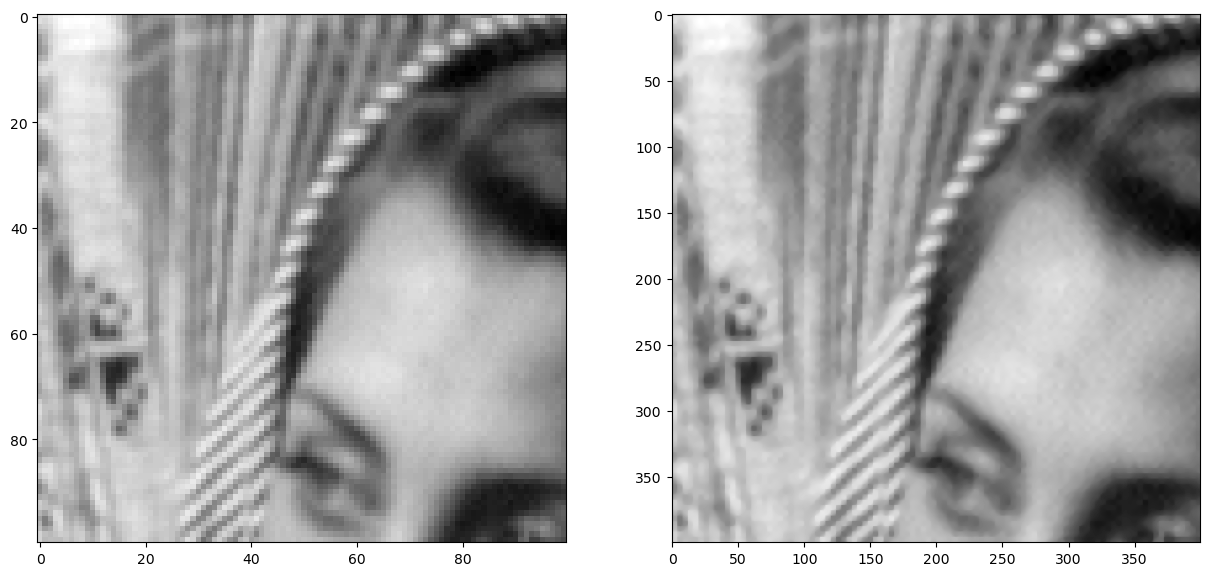

In [8]:
plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(w,cmap='gray')

L'image obtenue correspond bien à notre objectif : On a une image de résolution plus élevée grâce au suréchantillonnage, avec une lissage des pixels effectué par la méthode de descente de gradient à pas constant.

# Exercice 1

### 1)

L'ensemble $\mathcal{C}$ est non vide : En prenant $u_0$ tel que ${u_0}_{Ki+k,Kj+l}=v_{i,j}$, on obtient $Q(u_0)_{i,j} = \frac{1}{K^2}\sum_{k,l=0}^{K-1}{u_0}_{Ki+k,Kj+l}=\frac{1}{K^2}\sum_{k,l=0}^{K-1}v_{i,j}=v_{i,j}$. Ainsi, $Q(u_0)=v$, démontrant que $u_0 \in \mathcal{C}$.

Soit l'espace vectoriel suivant: $\mathcal{C'} = \{w \in \mathbb{R}^{(KN)^2} \,|\, Q(w)=0\}$.

Nous pouvons donc exprimer $\mathcal{C}$ comme la somme directe $\mathcal{u_0} + \mathcal{C'}$ car $Q $ est linéaire, formant ainsi un espace affine avec $\mathcal{C'}$ comme direction.

### 2)

Pour vérifier que l'opérateur qui associe $w \in \mathbb{R}^{(KN)^2}$ à $P_\mathcal{C}(w) \in \mathbb{R}^{(KN)^2}$, défini par 

$$
P_\mathcal{C}(w)_{i,j} = w_{i,j} - Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] } + v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] },
$$

est la projection orthogonale sur $\mathcal{C}$, nous devons vérifier deux points :

1. $Q(P_\mathcal{C}(w)) = v$, c'est-à-dire que $P_\mathcal{C}(w) \in \mathcal{C}$.
2. $w - P_\mathcal{C}(w)$ est orthogonal à $\mathcal{C}'$, où $\mathcal{C}'$ est l'espace vectoriel définissant la direction de $C$.

Commençons par montrer le 1. :

$$
\begin{align*}
Q(P_\mathcal{C}(w))_{i,j} &= Q(w_{i,j}) - Q(Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }) + Q(v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }) \\
&= Q(w_{i,j}) - Q(w_{i,j}) + Q(v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }) \\
&= Q(v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }) \\
&= v_{i,j}.
\end{align*}
$$

Cela montre que $P_\mathcal{C}(w) \in \mathcal{C}$.

Maintenant, voyons le 2. :

Soit $u \in \mathcal{C}'$, alors :

$$
\begin{align*}
\langle w-P_\mathcal{C}(w),u\rangle &= \sum_{i,j=0}^{KN-1}(w_{i,j}-P_\mathcal{C}(w)_{i,j})u_{i,j} \\
&= \sum_{i,j=0}^{KN-1}(w_{i,j}-w_{i,j}+Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }-v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] })u_{i,j} \\
&= \sum_{i,j=0}^{KN-1}(Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }-v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] })u_{i,j} \\
&= \sum_{i,j=0}^{KN-1}\sum_{k,l=0}^{K-1}(Q(w)_{\left[ \frac{i}{K}\right]K+k,\left[ \frac{j}{K}\right]K+l}-v_{\left[ \frac{i}{K}\right]K+k,\left[ \frac{j}{K}\right]K+l})u_{Ki+k,Kj+l} \\
&= \sum_{i,j=0}^{KN-1}(Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }-v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] })\sum_{k,l=0}^{K-1}u_{Ki+l,Kj+l}.
\end{align*}
$$

Cependant, puisque $u \in \mathcal{C}'$, $Q(u) = 0$, ce qui signifie que $\forall i,j \in \left\{1,...N\right\}^2, Q(u)_{i,j}=\frac{1}{K^2}\sum_{k,l=0}^{K-1}u_{Ki+l,Kj+l}=0 \Leftrightarrow \sum_{k,l=0}^{K-1}u_{Ki+l,Kj+l}=0$.

Ainsi, $\langle w-P_\mathcal{C}(w),u\rangle = 0$, montrant que $w - P_\mathcal{C}(w)$ est orthogonal à $\mathcal{C}'$.

Donc, pour tout $w \in \mathbb{R}^{(KN)^2}$, $P_C(w)_{i,j} = w_{i,j} - Q(w)_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] } + v_{\left[ \frac{i}{K}\right],\left[ \frac{j}{K}\right] }$ est bien la projection orthogonale sur $\mathcal{C}$.

### 3)

### 5)

1. **Initialisation :** Choisir une valeur initiale $ w $ dans $ \mathbb{R}^{(KN)^2}$ et calcule de la constante $L$ de lipschitz du gradient de $E_\beta$. .
   
2. **Itération tant que l'algorithme n'a pas convergé :**
    - calculer la direction de descente : $d = \nabla E_\beta(w)$
    - mettre à jour : $w' \leftarrow w - \frac{1}{L}d$
    - projeter sur $C$ : $w \leftarrow P_C(w')$
   
3. **Fin tant que**

### 6)

La fonction `echantillonne_image` applique l'opérateur d'échantillonnage $ Q $ et son opérateur adjoint :

- Lorsque le paramètre adjoint vaut $ 0 $, la fonction sous-échantillonne d'un rapport $ K $. Chaque pixel de l'image résultante est obtenu en prenant la moyenne pondérée des pixels voisins dans l'image de base, et le nombre de pixels est réduit par un facteur de $ K $. Cette opération est définie par la relation :
$$
\forall u \in \mathbb{R}^{(KN)^2}, \, \left(Q(u)\right)_{i,j} = \frac{1}{K^2}\sum_{k,l = 0}^{K-1} u_{Ki+k,Kj+l},~\forall~(i,j) \in \{0,...,N-1\}^2
$$

- Lorsque le paramètre adjoint vaut $ 1 $, la fonction renvoie une image zoomée (sur-échantillonnée), où chaque pixel de l'image initiale est divisé en $ K^2 $ pixels identiques, et le nombre total de pixels est multiplié par $ K^2 $. La fonction return à la fin l'image zoomée divisié par $ K^2 $, or nous ne faisons pas de moyenne ici donc il faudra multiplier le resultat par $ K^2 $ afin d'obtenir des pixels compris entre 0 et 255.

La fonction `zoom_TV` implémente l'algorithme de gradient avec projection pour résoudre le problème décrit à la question 5.

### 7)

In [9]:
K = 4

w1 = echantillonne_image(v,K,0)
w2 = K**2*echantillonne_image(v,K,1)

Taille de l'image initiale :  (100, 100)
Taille du sous-échantillonnage avec K = 4 :  (25, 25)
Taille du sur-échantillonnage avec K = 4 :  (400, 400)


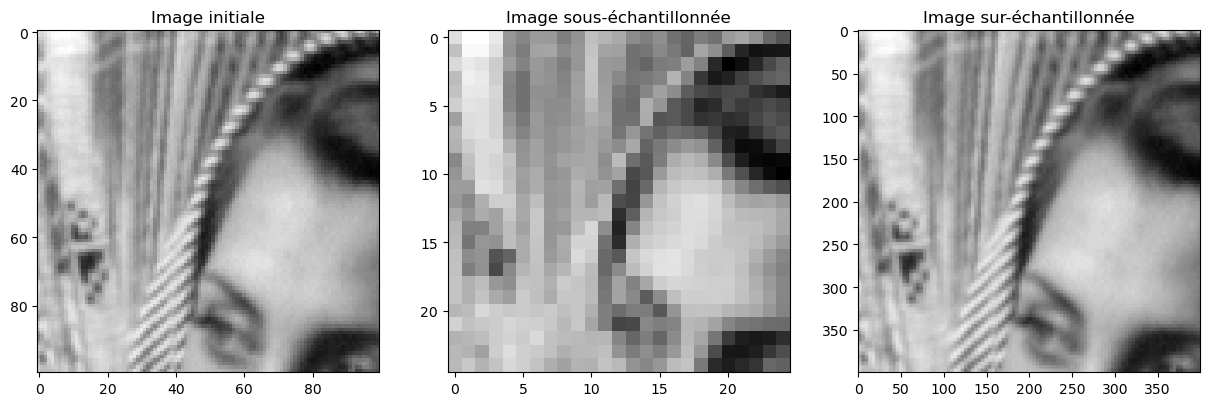

In [10]:
plt.figure(figsize = (15,30))
plt.subplot(1,3,1)
plt.imshow(v, cmap = 'gray')
plt.title("Image initiale")
print("Taille de l'image initiale : ", np.shape(v))
plt.subplot(1,3,2)
plt.imshow(w1, cmap = 'gray')
print(f'Taille du sous-échantillonnage avec K = {K} : ', np.shape(w1))
plt.title("Image sous-échantillonnée")
plt.subplot(1,3,3)
plt.imshow(w2, cmap = 'gray')
print(f'Taille du sur-échantillonnage avec K = {K} : ', np.shape(w2))
plt.title("Image sur-échantillonnée")
plt.show()

La taille de l'image initiale est de $100 \times 100$.

Sous-échantillonnage : image de taille  $25 \times 25$ car le facteur $K = 4$, il y a moins de pixels donc l'image est moins lisse.

Sur-échantillonnage : image de taille  $400 \times 400$ . L'image est plus pixélisée et plus lisse

In [11]:
w3 = zoom_TV(v,4,100)

iter =  0 fonction =  703601.9001332215 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  690662.3582636963 max contrainte =  1.1368683772161603e-13
iter =  2 fonction =  681277.2202739937 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  674048.6018858129 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  668261.8182184392 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  663494.8242948544 max contrainte =  1.4210854715202004e-13
iter =  6 fonction =  659479.386331876 max contrainte =  1.1368683772161603e-13
iter =  7 fonction =  656036.1930028152 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  653040.458985677 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  650402.4143944388 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  648055.6661297295 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  645949.9462075388 max contrainte =  1.4210854715202004e-13
iter =  12 fonction =  64404

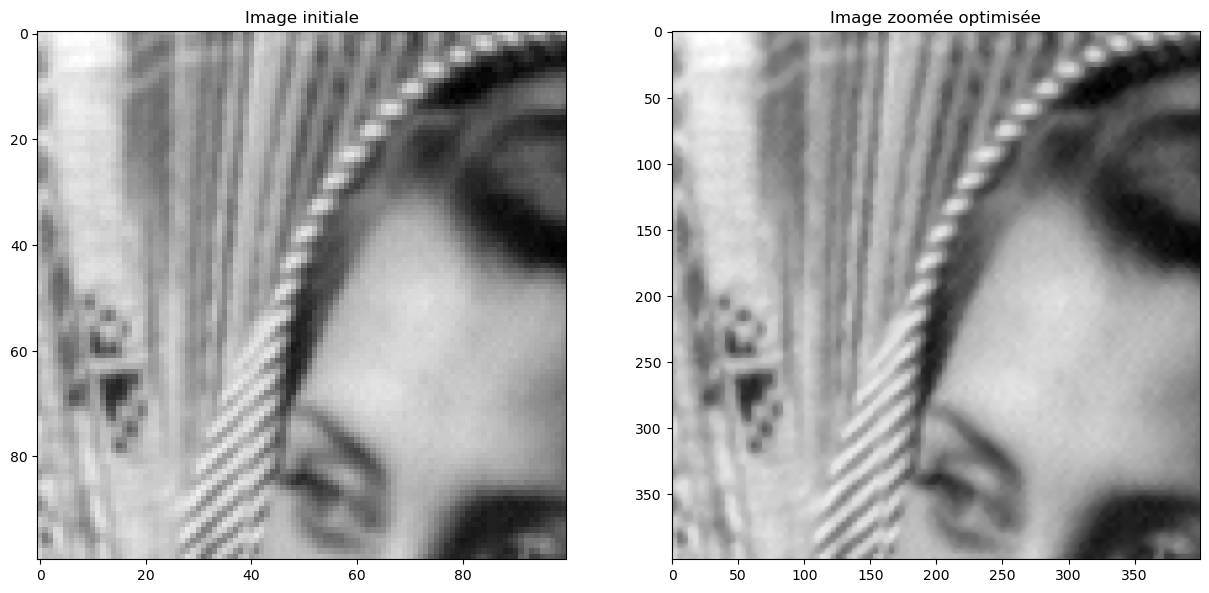

In [12]:
plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v, cmap = 'gray')
plt.title("Image initiale")
plt.subplot(1,2,2)
plt.imshow(w3, cmap = 'gray')
plt.title("Image zoomée optimisée")
plt.show()

Sur l'image zoomée, on remarque une nette diminution de la distinction entre les pixels par rapport à l'image initiale. 

### 8)

In [20]:
# on définit la règle d'Armijo

def règle_armijo(alpha_0,x,f,grad,d_x,c,beta): #d_x est la direction de descente d_x . grad_x <= 0
    test = 1
    pas = alpha_0 #Initialisation du pas
    redu = 0.5 # Initialisation du facteur de reduction
    
    # Armijo :
    
    while test: #Tant que test == 1
        
        
        # print(np.abs( f(x,beta)-f(x - pas*d_x,beta) ),c*pas*np.linalg.norm(grad(x,beta))**2)
        
        if np.abs( f(x,beta)-f(x - pas*d_x,beta) ) >= c*pas*np.linalg.norm(grad(x,beta))**2 :

            #On sors du while
            test = 0
            
        else:
            #Sinon on reduit le pas en multipliant par un certain beta definit arbitrairement dans ]0,1[
            pas = pas*redu
            #print(pas)
            #On continue dans la boucle while car test = 1
            
    return pas 


In [21]:
#Initialisation
c = 0.5
alpha_0=0.9
beta=1


def zoom_TV_armijo(v, K, nbIter):
    F_TV = []
    # Initialisation proche de la solution
    out = (K * K) * echantillonne_image(v, K, 1)  

    for it in range(nbIter):
        
        d = grad_TV(out, beta)
        
        norm_d = np.linalg.norm(d)  # Norme du gradient
        
        pas = règle_armijo(alpha_0,out,TV,grad_TV,d,c,beta)

        out = out -  pas * d
        
        out = projection(out, v, K)
        
        F_TV += [TV(out,beta)]
        
        print('iter =', it, 'fonction =', TV(out, beta),
              'max contrainte =', np.abs(echantillonne_image(out, K, 0) - v).max(),'pas =', pas)

    return out,F_TV


In [22]:
v = u[0:100,0:100]
w,L = zoom_TV_armijo(v,K,100)


iter = 0 fonction = 678005.2808778735 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 1 fonction = 662993.5930471215 max contrainte = 1.1368683772161603e-13 pas = 0.45
iter = 2 fonction = 656339.8605563727 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 3 fonction = 648272.0584576123 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 4 fonction = 644100.3594361155 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 5 fonction = 640436.7363275351 max contrainte = 1.1368683772161603e-13 pas = 0.45
iter = 6 fonction = 639222.6706273156 max contrainte = 1.1368683772161603e-13 pas = 0.45
iter = 7 fonction = 635197.4159931105 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 8 fonction = 633336.7554270285 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 9 fonction = 630884.6725419692 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 10 fonction = 630956.9805442351 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 11 fonction = 6

iter = 92 fonction = 609699.6771713812 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 93 fonction = 606595.0294755931 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 94 fonction = 609794.2599098197 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 95 fonction = 606537.3536597275 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 96 fonction = 609692.9210637045 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 97 fonction = 606487.285250782 max contrainte = 1.1368683772161603e-13 pas = 0.225
iter = 98 fonction = 609764.0925886601 max contrainte = 1.1368683772161603e-13 pas = 0.9
iter = 99 fonction = 606434.550638362 max contrainte = 1.1368683772161603e-13 pas = 0.225


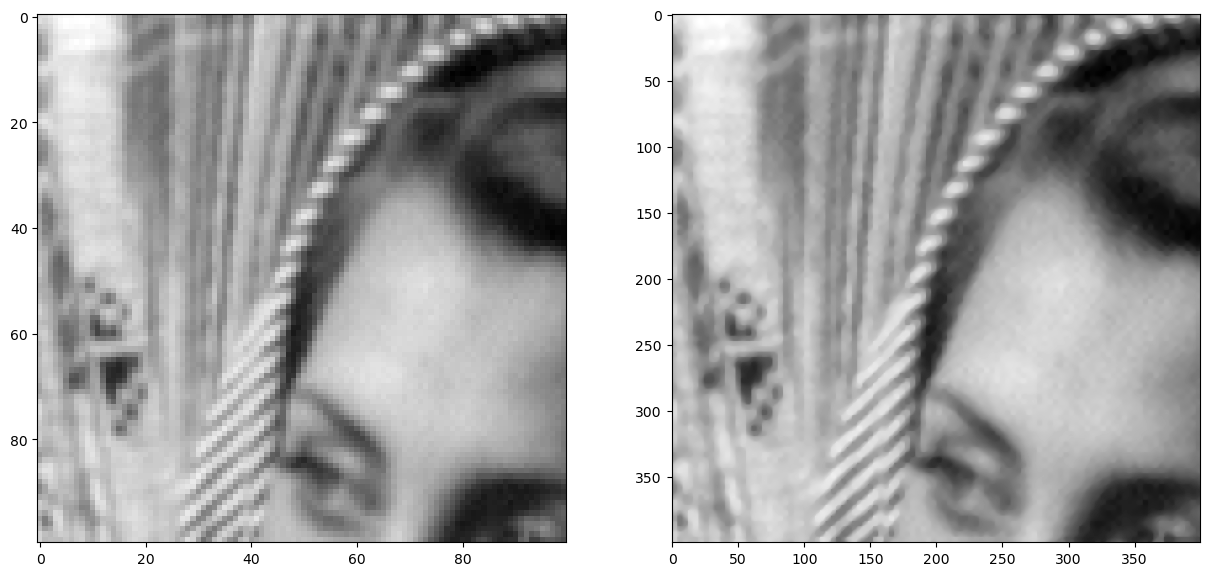

In [23]:
plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(w,cmap='gray')

### 9)

In [24]:
def zoom_TV(v,K,nbIter,pas):

    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_TV(out,beta)
        out = out - pas * d
        out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', TV(out,beta) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        
    return out

In [25]:
nbIter = 25

imagepas = []
pas = [0.25,0.5,0.9,1]
for i in range(len(pas)):
    imagepas.append( zoom_TV(v,K,nbIter,pas[i]) )

iter =  0 fonction =  703601.9001332215 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  690662.3582636963 max contrainte =  1.1368683772161603e-13
iter =  2 fonction =  681277.2202739937 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  674048.6018858129 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  668261.8182184392 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  663494.8242948544 max contrainte =  1.4210854715202004e-13
iter =  6 fonction =  659479.386331876 max contrainte =  1.1368683772161603e-13
iter =  7 fonction =  656036.1930028152 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  653040.458985677 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  650402.4143944388 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  648055.6661297295 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  645949.9462075388 max contrainte =  1.4210854715202004e-13
iter =  12 fonction =  64404

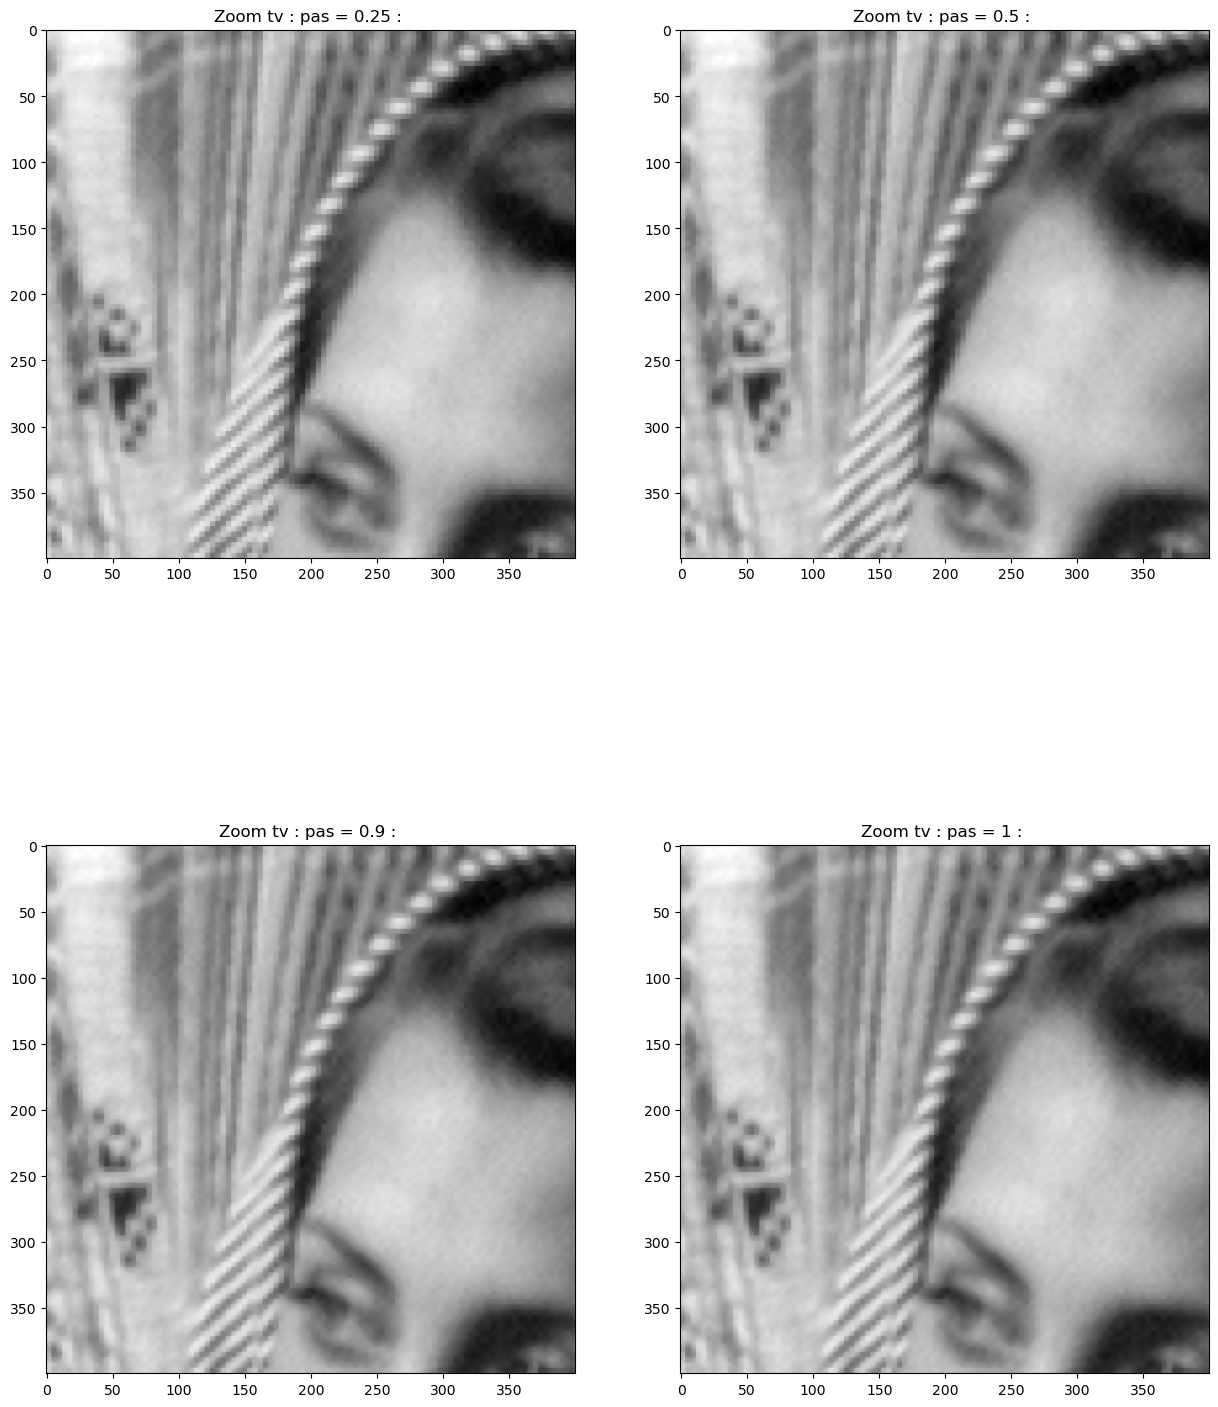

In [26]:
plt.figure(figsize=(15, 30))

for i in range(len(imagepas)):
    
    plt.subplot(3, 2, i+1)
    plt.imshow(imagepas[i], cmap='gray')
    plt.title(f'Zoom tv : pas = {pas[i]} : ')


plt.show()


Nous remarquons moins de pixel pour des valeurs de pas autour de 1.

# Exercice 2

### 1)

In [27]:
def F(out,v,Lambda,Beta,K):
    sx , sy = np.shape(out)
    return TV(out,Beta) + (Lambda*np.linalg.norm(echantillonne_image(out,K,0) - v)**2)


def grad_F(out,v,Lambda,Beta,K):
    sx , sy = np.shape(out)
    Q = echantillonne_image(out,K,0)
    B = echantillonne_image(Q - v,K,1)
    
    return grad_TV(out,Beta) + 2*Lambda*B
    

#### Algorithme du gradient à pas constant

In [29]:
# def Algo_grad_pas_cste(v,Lambda,K,nbIter,eps):
#     beta = 1
#     pas = 1/((4/beta)+2*Lambda)
#     it = 0

#     out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
# #    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)
#     d = grad_F(out,v,Lambda,beta,K)
#     out1 = out - pas * d
#     F_TV = [out1]
#     while it < (nbIter):
#         out = np.copy(out1)
#         d = grad_F(out,v,Lambda,beta,K)
#         out1 = out - pas * d
#         F_TV = [out1]
#         it += 1
#         #print( 'iter = ', it , 'fonction = ', F(out1,v,Lambda,beta,K) ,\
#               #'max contrainte = ', np.abs(echantillonne_image(out1,K,0)-v).max() )
#     return out1,F_TV


def Algo_grad_pas_cste(v, Lambda, K, nbIter, pas):
    beta = 1
    pas = 1 / ((4 / beta) + 2 * Lambda)  
    it = 0

    out = (K * K) * echantillonne_image(v, K, 1)  # initialisation proche de la solution
    # out = np.zeros(K * np.shape(v))  # initialisation plus lointaine (pour tester)
    F_TV = [out]
    
    while it < nbIter:
        d = grad_F(out, v, Lambda, beta, K)
        out = out - pas * d
        F_TV.append(out)
        it += 1
        print('iter = ', it , 'fonction = ', F(out,v,Lambda,beta,K) ,\
               'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        
    return out, F_TV


In [30]:
v = u[0:100,0:100]
Lambda = 1
K = 4
w1,L1 = Algo_grad_pas_cste(v,Lambda,K,100,10**-3)

iter =  1 fonction =  705905.0587762941 max contrainte =  0.15961405940416284
iter =  2 fonction =  691821.3582624248 max contrainte =  0.31588952310853813
iter =  3 fonction =  680399.4528765046 max contrainte =  0.46889217177347575
iter =  4 fonction =  670769.7973082406 max contrainte =  0.6186863298711103
iter =  5 fonction =  662468.8096319701 max contrainte =  0.7653351718202259
iter =  6 fonction =  655203.5814950941 max contrainte =  0.9089008275534525
iter =  7 fonction =  648771.581319191 max contrainte =  1.0494444407553374
iter =  8 fonction =  643025.1859314026 max contrainte =  1.1870262006997905
iter =  9 fonction =  637853.0508452916 max contrainte =  1.3217053563460155
iter =  10 fonction =  633168.973624497 max contrainte =  1.4535402198211358
iter =  11 fonction =  628904.6821507979 max contrainte =  1.5825881646578637
iter =  12 fonction =  625005.0558426431 max contrainte =  1.7089471007479347
iter =  13 fonction =  621424.876230088 max contrainte =  1.832638694532

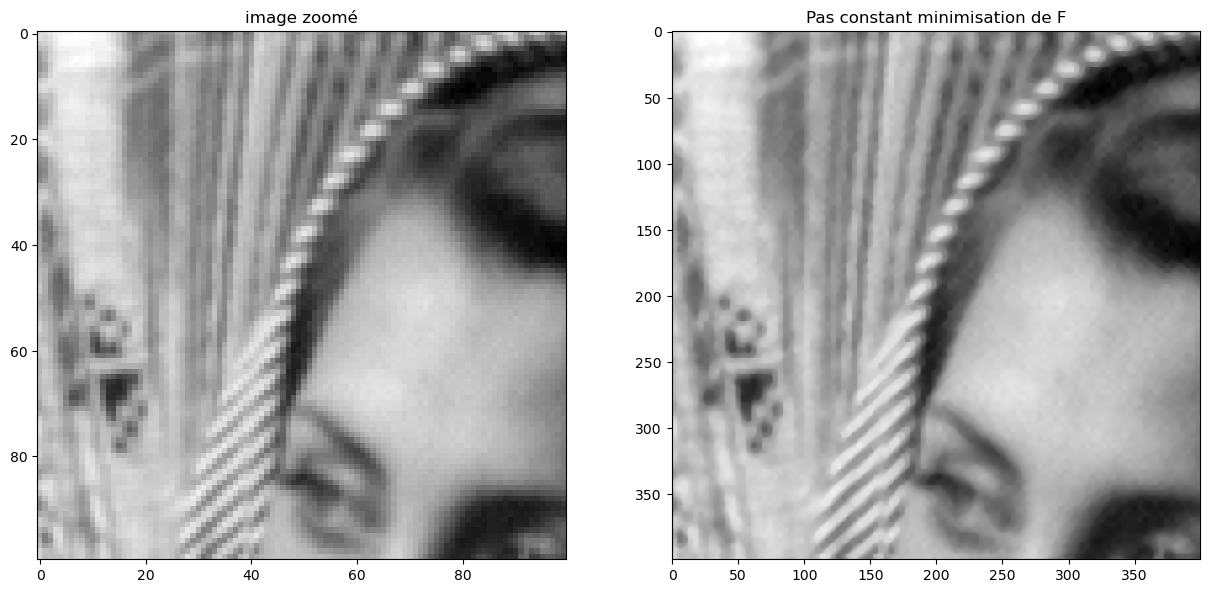

In [31]:
plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.title('image zoomé')
plt.subplot(1,2,2)
plt.title('Pas constant minimisation de F')
plt.imshow(w,cmap='gray')

#### Algorithme du pas d'Armijo

In [33]:
def Algo_grad_pas_armijo(v, Lambda, K, nbIter, eps):
    beta = 1
    it = 0

    out = (K * K) * echantillonne_image(v, K, 1)  # initialisation proche de la solution
    # out = np.zeros(K * np.shape(v))  # initialisation plus lointaine (pour tester)
    F_TV = []
    
    while it < nbIter:
        
        d = grad_F(out, v, Lambda, beta, K)
        pas = 1
        
        while F(out - pas * d, v, Lambda, beta, K) > (F(out, v, Lambda, beta, K)) - 1e-3 * pas * (np.linalg.norm(d) ** 2):
            pas = pas / 2
        out = out - pas * d
        it += 1
        F_TV.append(out)
        
        print( 'iter = ', it , 'fonction = ', F(out,v,Lambda,beta,K) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max(),'pas =', pas )
    return out, F_TV


In [35]:
v = u[0:100,0:100]
Lambda = 1
K = 4
w2,L2 = Algo_grad_pas_armijo(v,Lambda,K,100,10**-3)

iter =  1 fonction =  658956.2892766999 max contrainte =  0.9576843564250197 pas = 1
iter =  2 fonction =  644274.6778295583 max contrainte =  1.7947526769951878 pas = 1
iter =  3 fonction =  614668.3900544996 max contrainte =  2.1598860353548446 pas = 0.5
iter =  4 fonction =  609450.227716513 max contrainte =  2.5018485872568874 pas = 0.5
iter =  5 fonction =  608641.6512401934 max contrainte =  2.821979503083469 pas = 0.5
iter =  6 fonction =  595004.6387984254 max contrainte =  2.9718249856808967 pas = 0.25
iter =  7 fonction =  593870.8950183272 max contrainte =  3.551997932037196 pas = 1
iter =  8 fonction =  585302.168071251 max contrainte =  3.678453522253079 pas = 0.25
iter =  9 fonction =  584249.3724525527 max contrainte =  3.923251944835002 pas = 0.5
iter =  10 fonction =  581054.5730232873 max contrainte =  4.037813544318809 pas = 0.25
iter =  11 fonction =  580779.8458609256 max contrainte =  4.259588169480111 pas = 0.5
iter =  12 fonction =  577811.6049792315 max contrai

iter =  95 fonction =  556546.6092862412 max contrainte =  7.369172853017304 pas = 0.25
iter =  96 fonction =  556500.1612132362 max contrainte =  7.37346689075504 pas = 0.25
iter =  97 fonction =  556455.9410146355 max contrainte =  7.377619180935241 pas = 0.25
iter =  98 fonction =  556413.502483947 max contrainte =  7.381634266334018 pas = 0.25
iter =  99 fonction =  556372.544340076 max contrainte =  7.3855165464230055 pas = 0.25
iter =  100 fonction =  556332.8538973092 max contrainte =  7.389270281851324 pas = 0.25


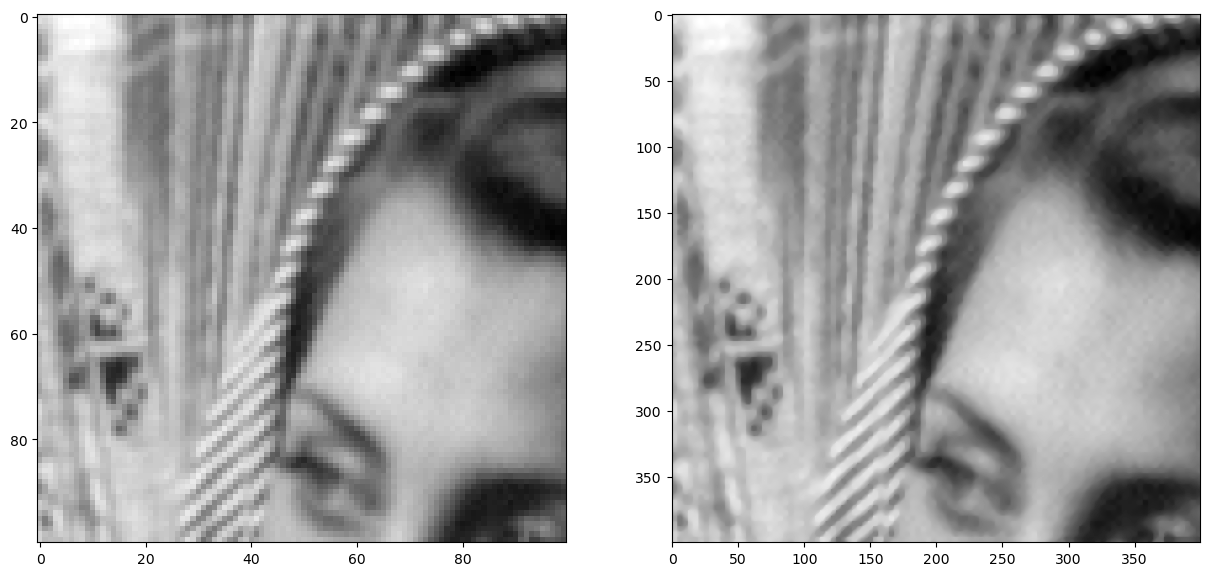

In [36]:
plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(w,cmap='gray')

### 4)

Lorsque $\mathcal{Q}$ est l'identité c'est à dire que $K= 1$, l'énergie minimisée par notre programme est :
$$
F_{\lambda}(w) =  E(w) + \lambda \sum_{i,j=0}^{N-1} (w_{i,j} - v_{i,j})^2
$$
$$
 = \sum_{i,j=0}^{N-1}  \left( \sqrt{|\nabla w_{i,j}|^2+\beta} \right).
 + \lambda \sum_{i,j=0}^{N-1} (w_{i,j} - v_{i,j})^2
$$

Au TP1 nous avions à minimisé :
$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2 + \lambda \sum_{i,j=0}^{N-1}
(w_{i,j}-v_{i,j})^2,
$$

donc la même fonction à une constante additive $\beta$ près pour la norme au carré du gradient

# Exercice 3

### 1)

In [42]:
def H(w):
    I, J = w.shape
    out = np.zeros_like(w)
    for i in range(I):
        for j in range(J):
            for m in [-1, 0, 1]:
                for n in [-1, 0, 1]:
                    # Utilisation de l'opération modulo pour gérer les bords périodiques
                    a = w[(i + m) % I, (j + n) % J]
                    out[i, j] += a
    return out

### 2)

In [43]:
def F2(out,v,beta,Lambda):
    norme = np.linalg.norm(H(out) - v,ord = 'fro')
    return TV(out,beta) + Lambda*norme**2


def grad_F2(out,v,beta,Lambda):
    tmp = H(H(out) - v)
    return grad_TV(out,beta) + 2*Lambda*(tmp)


def bruit(image_base,sigma):
    return image_base + np.random.normal(0,sigma,size = image_base.shape)



### Déconvolution avec pas constant

In [39]:
def deconvolution(v, beta, Lambda, nbIter):
    pas = beta/4
    out = np.copy(v)     # initialisation proche de la solution
    F = []
    
    for it in range(nbIter):
        d = grad_F2(out, v, beta, Lambda)
        out = out - pas * d
        
        fonction_F2 = F2(out, v, beta, Lambda)
        F.append(fonction_F2)
        
        print('iter = ', it, 'fonction = ', F2(out, v, beta, Lambda), \
              'max contrainte = ', np.abs(H(out) - v).max())
    return out, F

### Déconvolution avec Armijo

In [40]:
def deconv_F_Armijo(v, Lambda, nbIter, beta, tmax):
    B = 0.1
    out = np.copy(v)  # initialisation proche de la solution
    F = []

    for it in range(nbIter):
        gradient_F2 = grad_F2(out, v, beta, Lambda)
        pas = 1
        while F2(out - pas * gradient_F2, v, beta, Lambda) > F2(out, v, beta, Lambda) - 1e-3 * pas * (np.linalg.norm(gradient_F2) ** 2):
            pas = pas / 2

        out = out - pas * gradient_F2

        fonction_F2 = F2(out, v, beta, Lambda)
        F.append(fonction_F2)
        
        max_contrainte = np.abs(out - v).max()
        
        print('iter =', it, 'fonction =', fonction_F2, 'max contrainte =', max_contrainte)
    return out, F


### 3)

### Déconvolution avec pas constant

In [44]:
v = u[0:100,0:100] 
v_bruit = bruit(H(v),2)

w1_cst, L1_cst = deconvolution(v_bruit,0.01,0.01,100)
w2_cst, L2_cst = deconvolution(v_bruit,0.01,0.1,100)
w3_cst, L3_cst = deconvolution(v_bruit,0.01,1,100)

iter =  0 fonction =  11325114161.934889 max contrainte =  15507.27879954373
iter =  1 fonction =  11233780544.514257 max contrainte =  15445.37026770638
iter =  2 fonction =  11143183834.028133 max contrainte =  15383.709385245531
iter =  3 fonction =  11053318083.274305 max contrainte =  15322.295160418673
iter =  4 fonction =  10964177393.056341 max contrainte =  15261.12660545539
iter =  5 fonction =  10875755911.79638 max contrainte =  15200.202736541456
iter =  6 fonction =  10788047835.151224 max contrainte =  15139.522573803066
iter =  7 fonction =  10701047405.631723 max contrainte =  15079.085141291054
iter =  8 fonction =  10614748912.225191 max contrainte =  15018.889466965224
iter =  9 fonction =  10529146690.019632 max contrainte =  14958.934582678716
iter =  10 fonction =  10444235119.827951 max contrainte =  14899.219524162463
iter =  11 fonction =  10360008627.813982 max contrainte =  14839.743331009677
iter =  12 fonction =  10276461685.126987 max contrainte =  14780.

iter =  7 fonction =  59016469837.80227 max contrainte =  11240.794243168677
iter =  8 fonction =  54345090372.48794 max contrainte =  10792.453221164043
iter =  9 fonction =  50043667570.634476 max contrainte =  10362.037409045146
iter =  10 fonction =  46082892705.98291 max contrainte =  9948.829147103737
iter =  11 fonction =  42435779467.67557 max contrainte =  9552.139526950941
iter =  12 fonction =  39077479898.71055 max contrainte =  9171.30724009481
iter =  13 fonction =  35985114929.21651 max contrainte =  8805.697477093248
iter =  14 fonction =  33137618342.7262 max contrainte =  8454.700891131379
iter =  15 fonction =  30515593102.846077 max contrainte =  8117.732695696263
iter =  16 fonction =  28101179075.017113 max contrainte =  7794.2320007949975
iter =  17 fonction =  25877931229.704453 max contrainte =  7483.660333126306
iter =  18 fonction =  23830707498.566277 max contrainte =  7185.4997813752425
iter =  19 fonction =  21945565519.059143 max contrainte =  6899.253168

iter =  13 fonction =  10318910.662016096 max contrainte =  191.83005348448387
iter =  14 fonction =  8298906.56124582 max contrainte =  176.54324509953221
iter =  15 fonction =  6899402.245539001 max contrainte =  163.9031252864545
iter =  16 fonction =  5858661.784812964 max contrainte =  153.194843032883
iter =  17 fonction =  5049322.6964599425 max contrainte =  143.93753155091918
iter =  18 fonction =  4401650.28562934 max contrainte =  135.80091474997016
iter =  19 fonction =  3873084.9273861633 max contrainte =  128.5529103554561
iter =  20 fonction =  3435367.9734084453 max contrainte =  122.02644426142933
iter =  21 fonction =  3068600.713576256 max contrainte =  116.09823019847181
iter =  22 fonction =  2758209.9887549016 max contrainte =  110.67504722372223
iter =  23 fonction =  2493231.5067411284 max contrainte =  105.68474975479944
iter =  24 fonction =  2265257.293274828 max contrainte =  101.07028966959047
iter =  25 fonction =  2067742.533272089 max contrainte =  96.78

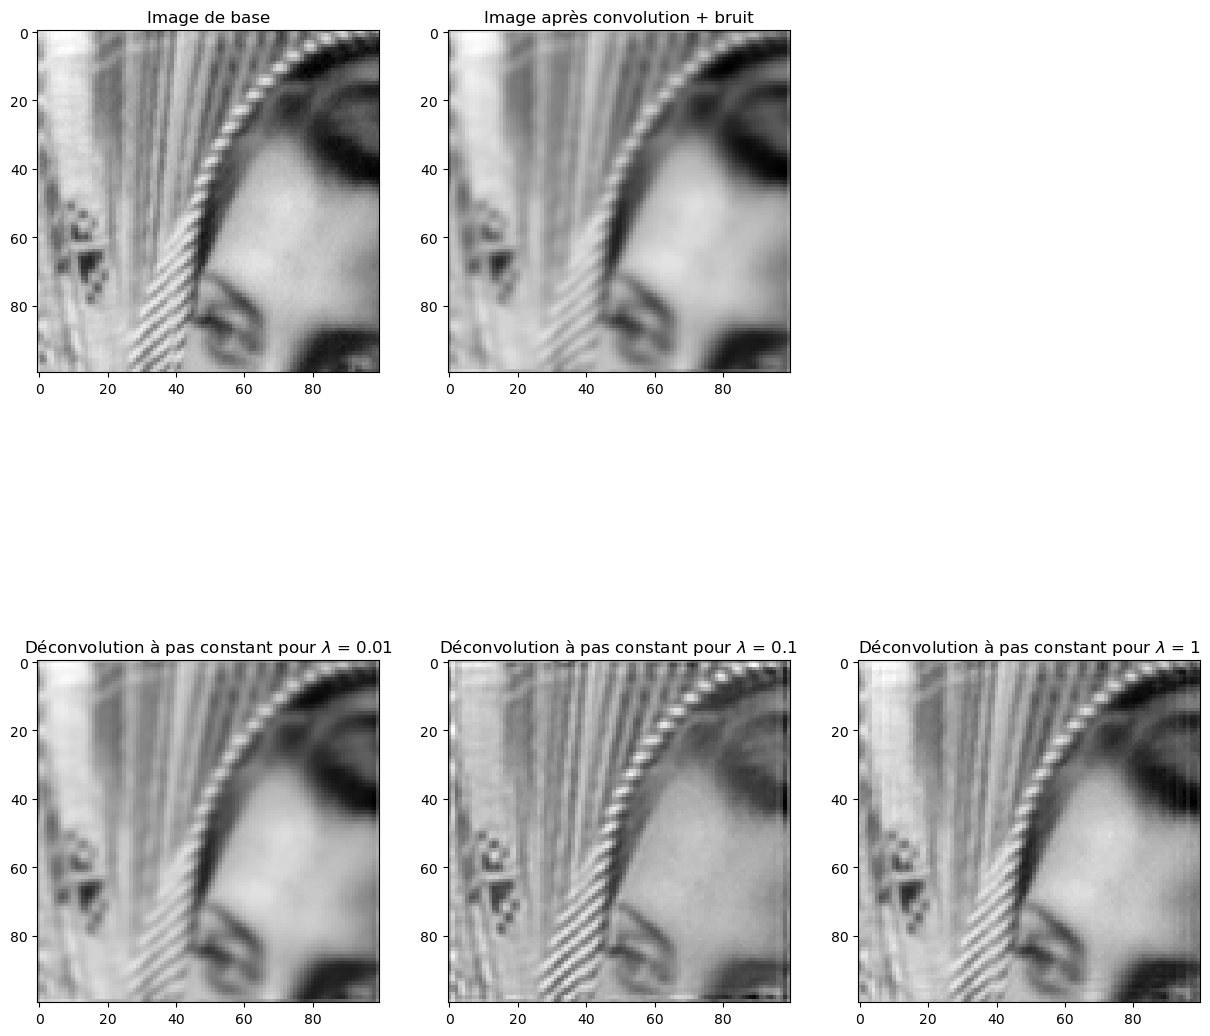

In [45]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.imshow(v,cmap ='gray')
plt.title("Image de base")
plt.subplot(2,3,2)
plt.imshow(v_bruit,cmap ='gray')
plt.title("Image après convolution + bruit")
plt.subplot(2,3,4)
plt.imshow(w1_cst,cmap ='gray')
plt.title("Déconvolution à pas constant pour $\lambda$ = 0.01")
plt.subplot(2,3,5)
plt.imshow(w2_cst,cmap ='gray')
plt.title("Déconvolution à pas constant pour $\lambda$ = 0.1")
plt.subplot(2,3,6)
plt.imshow(w3_cst,cmap ='gray')
plt.title("Déconvolution à pas constant pour $\lambda$ = 1")
plt.show()

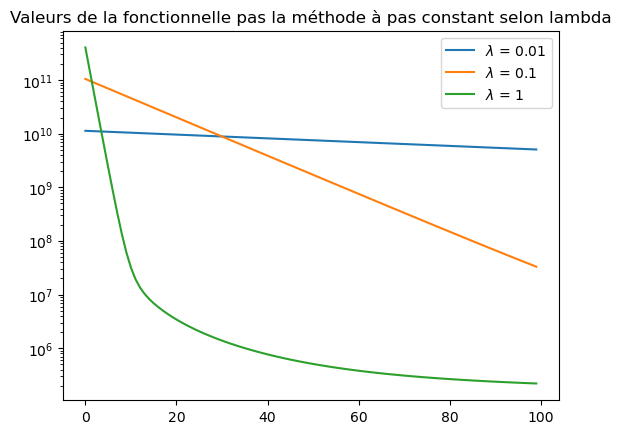

In [46]:
n = np.linspace(0,99,100)
plt.semilogy(n,L1_cst, label = '$\lambda$ = 0.01')
plt.semilogy(n,L2_cst, label = '$\lambda$ = 0.1')
plt.semilogy(n,L3_cst, label = '$\lambda$ = 1')
plt.title("Valeurs de la fonctionnelle pas la méthode à pas constant selon lambda")
plt.legend()
plt.show()

### Déconvolution avec Armijo

In [47]:
w1_arm, L1_arm = deconv_F_Armijo(v_bruit, 0.01, 100, 0.01, 1)
w2_arm, L2_arm = deconv_F_Armijo(v_bruit, 0.1, 100, 0.01, 1)
w3_arm, L3_arm = deconv_F_Armijo(v_bruit, 1, 100, 0.01, 1)

iter = 0 fonction = 4348858039.202441 max contrainte = 2790.176753549514
iter = 1 fonction = 1663478204.9605343 max contrainte = 1116.2912355142084
iter = 2 fonction = 637196447.8187157 max contrainte = 2119.2525791373564
iter = 3 fonction = 244332972.42066348 max contrainte = 1518.8066031508642
iter = 4 fonction = 93772319.35173944 max contrainte = 1884.0753168555611
iter = 5 fonction = 36048690.0589054 max contrainte = 1663.9127567038527
iter = 6 fonction = 13904393.546564687 max contrainte = 1802.267671624754
iter = 7 fonction = 5408138.323226254 max contrainte = 1720.0356625359236
iter = 8 fonction = 2146082.3799049594 max contrainte = 1773.1494758047793
iter = 9 fonction = 894055.5436079679 max contrainte = 1742.289626263414
iter = 10 fonction = 412584.2265203861 max contrainte = 1761.6699981871247
iter = 11 fonction = 227877.0935210835 max contrainte = 1750.3400985339597
iter = 12 fonction = 156398.56168192506 max contrainte = 1755.7567793365665
iter = 13 fonction = 128960.927262

iter = 9 fonction = 171199.3408677027 max contrainte = 1746.497306739629
iter = 10 fonction = 161165.9871351109 max contrainte = 1748.348273710254
iter = 11 fonction = 154123.37840124557 max contrainte = 1748.351556379169
iter = 12 fonction = 149062.32974197005 max contrainte = 1749.5969419770474
iter = 13 fonction = 145350.08220026226 max contrainte = 1749.213695806365
iter = 14 fonction = 142583.49744912496 max contrainte = 1750.2602006094833
iter = 15 fonction = 140479.5701062928 max contrainte = 1749.7813915712427
iter = 16 fonction = 138870.30399819024 max contrainte = 1750.6971292938692
iter = 17 fonction = 137633.10708421105 max contrainte = 1750.153880140522
iter = 18 fonction = 136686.4228333935 max contrainte = 1750.9912639808038
iter = 19 fonction = 135959.9756824107 max contrainte = 1750.400554959017
iter = 20 fonction = 135417.83666042262 max contrainte = 1751.1925932654635
iter = 21 fonction = 135022.51148152392 max contrainte = 1750.564088591411
iter = 22 fonction = 1347

iter = 18 fonction = 227996.61782404556 max contrainte = 1749.7384853261287
iter = 19 fonction = 213615.02632917155 max contrainte = 1749.618112323375
iter = 20 fonction = 210103.83385369874 max contrainte = 1749.930556273541
iter = 21 fonction = 195769.99894515157 max contrainte = 1749.773298094789
iter = 22 fonction = 191867.9810919179 max contrainte = 1749.8906470836464
iter = 23 fonction = 190263.48197261873 max contrainte = 1749.768710412416
iter = 24 fonction = 183872.3646597714 max contrainte = 1749.8807839303406
iter = 25 fonction = 182299.85950365211 max contrainte = 1749.7860068277764
iter = 26 fonction = 175730.52501696395 max contrainte = 1749.9008149382146
iter = 27 fonction = 173714.57533218447 max contrainte = 1749.8411807191353
iter = 28 fonction = 172689.68094973644 max contrainte = 1749.9331733237993
iter = 29 fonction = 169645.85980655917 max contrainte = 1749.8623619285493
iter = 30 fonction = 168260.63860931754 max contrainte = 1749.9357794600292
iter = 31 fonction

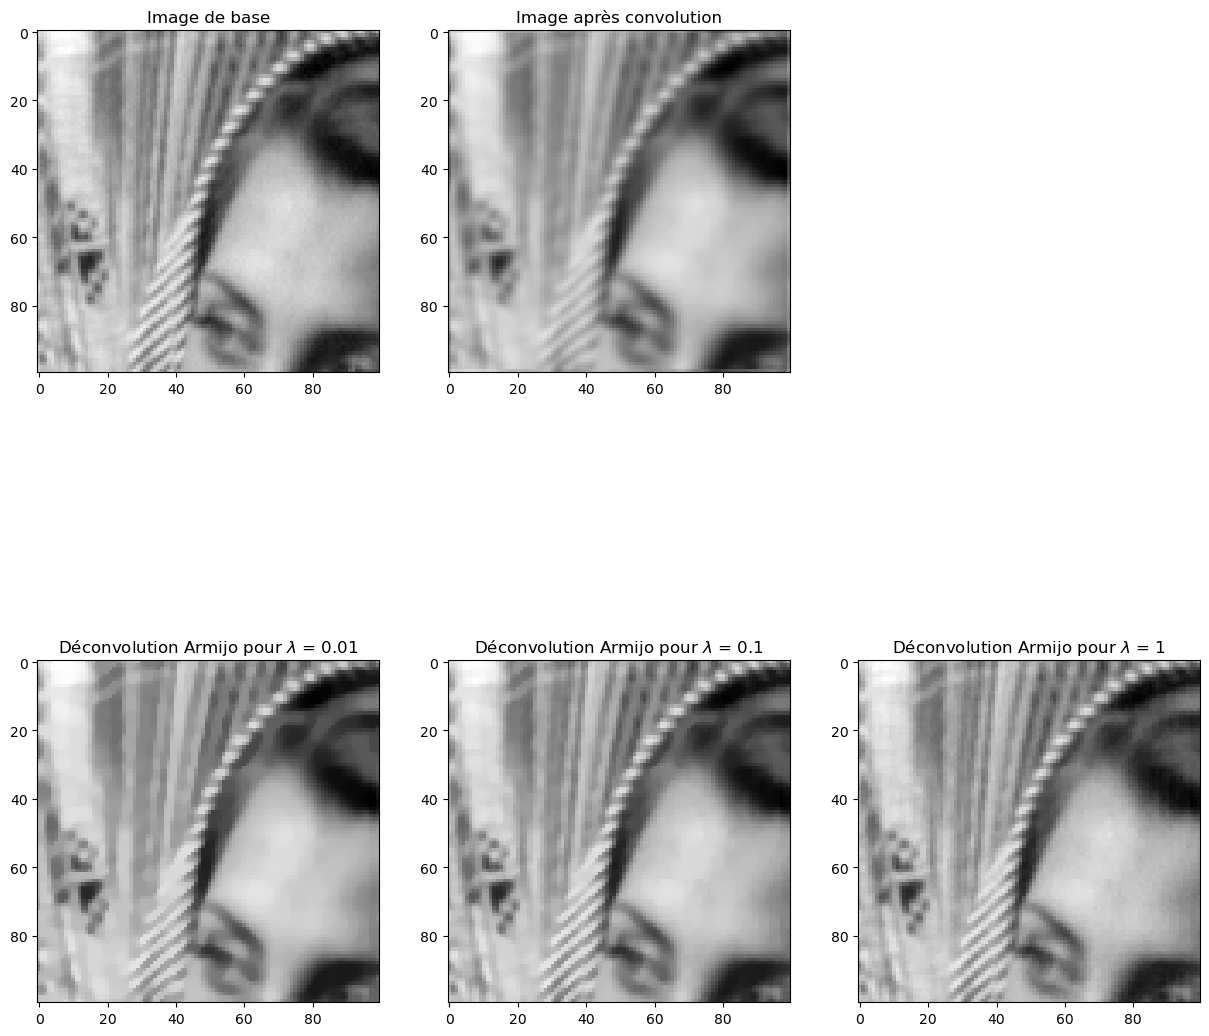

In [49]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.imshow(v,cmap ='gray')
plt.title("Image de base")
plt.subplot(2,3,2)
plt.imshow(v_bruit,cmap ='gray')
plt.title("Image après convolution")
plt.subplot(2,3,4)
plt.imshow(w1_arm,cmap ='gray')
plt.title("Déconvolution Armijo pour $\lambda$ = 0.01")
plt.subplot(2,3,5)
plt.imshow(w2_arm,cmap ='gray')
plt.title("Déconvolution Armijo pour $\lambda$ = 0.1")
plt.subplot(2,3,6)
plt.imshow(w3_arm,cmap ='gray')
plt.title("Déconvolution Armijo pour $\lambda$ = 1")
plt.show()

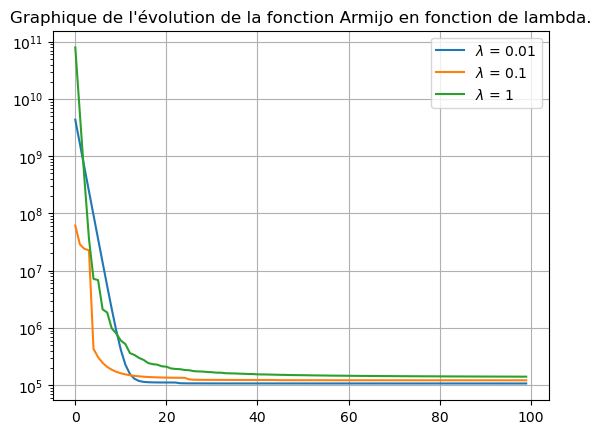

In [50]:
n = np.linspace(0,99,100)
plt.semilogy(n,L1_arm, label = '$\lambda$ = 0.01')
plt.semilogy(n,L2_arm, label = '$\lambda$ = 0.1')
plt.semilogy(n,L3_arm, label = '$\lambda$ = 1')
plt.title("Graphique de l'évolution de la fonction Armijo en fonction de lambda.")
plt.grid()
plt.legend()
plt.show()